<a href="https://colab.research.google.com/github/nrichardrexon/AI-Driven-Intrusion-Detection-System-for-Containerized-Environments/blob/main/Project_Phase_1_Module_2_Base_Model_Comparision_Version_1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ============================================
# 📂 Segment 0 — Setup Environment
# ============================================

# --- Install required packages ---
!pip install pandas numpy scikit-learn statsmodels torch xgboost matplotlib seaborn holidays tqdm

# --- Import libraries ---
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import statsmodels.api as sm
import xgboost as xgb
from tqdm import tqdm

# For reproducibility
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# --- Mount Google Drive ---
from google.colab import drive

print("🔹 Mounting Google Drive...")
drive.mount('/content/drive', force_remount=True)
print("✅ Google Drive mounted successfully!")

# --- Set base paths ---
BASE_DIR = '/content/drive/MyDrive/Colab Notebooks/Smart Grid Phase 1'  # Project folder in Drive

DATA_DIR = os.path.join(BASE_DIR, 'processed')         # Checkpoint 1 processed data
MODEL_DIR = os.path.join(BASE_DIR, 'models')
OUTPUT_DIR = os.path.join(BASE_DIR, 'outputs')
REPORTS_DIR = os.path.join(OUTPUT_DIR, 'reports')

# --- Create directories if they don't exist ---
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(REPORTS_DIR, exist_ok=True)

# --- Confirmation prints ---
print(f"📂 Directories set:")
print(f"DATA_DIR: {DATA_DIR}")
print(f"MODEL_DIR: {MODEL_DIR}")
print(f"OUTPUT_DIR: {OUTPUT_DIR}")
print(f"REPORTS_DIR: {REPORTS_DIR}")

# --- Quick verification of processed data ---
print("\n📂 Checking processed data directory contents...")
if os.path.exists(DATA_DIR):
    files = os.listdir(DATA_DIR)
    if files:
        print(f"✅ Processed data files found ({len(files)} files):")
        for f in files:
            print(f" - {f}")
    else:
        print("⚠ No files found in processed data directory.")
else:
    print(f"❌ Processed data directory not found: {DATA_DIR}")


🔹 Mounting Google Drive...
Mounted at /content/drive
✅ Google Drive mounted successfully!
📂 Directories set:
DATA_DIR: /content/drive/MyDrive/Colab Notebooks/Smart Grid Phase 1/processed
MODEL_DIR: /content/drive/MyDrive/Colab Notebooks/Smart Grid Phase 1/models
OUTPUT_DIR: /content/drive/MyDrive/Colab Notebooks/Smart Grid Phase 1/outputs
REPORTS_DIR: /content/drive/MyDrive/Colab Notebooks/Smart Grid Phase 1/outputs/reports

📂 Checking processed data directory contents...
✅ Processed data files found (392 files):
 - snapshots
 - processed_splits
 - gefcom_wind_tasks
 - backups
 - backups_segment1_2
 - GEFCom_Load_Task 2_L2-train_cleaned.csv
 - GEFCom_Load_Task 1_L1-benchmark_cleaned.csv
 - GEFCom_Load_Task 7_L7-benchmark_cleaned.csv
 - GEFCom_Load_Task 2_L2-benchmark_cleaned.csv
 - GEFCom_Load_Task 6_L6-benchmark_cleaned.csv
 - GEFCom_Load_Task 15_L15-train_cleaned.csv
 - GEFCom_Load_Task 6_L6-train_cleaned.csv
 - GEFCom_Load_Task 15_L15-benchmark_cleaned.csv
 - GEFCom_Load_Task 7_L7-t

In [2]:
# ============================================
# 📂 Segment 1 — Directory Setup & Inspection
# ============================================

from pathlib import Path

# --- Define directories based on Segment 0 ---
DATA_DIR = Path(BASE_DIR) / "processed"   # Matches where Checkpoint 1 stores processed data
MODEL_DIR = Path(BASE_DIR) / "models"
OUTPUT_DIR = Path(BASE_DIR) / "outputs"
REPORTS_DIR = OUTPUT_DIR / "reports"

# --- Create directories if they do not exist ---
DATA_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

# --- Verify existence ---
print("✅ Directory setup verification:")
print(f"DATA_DIR exists: {DATA_DIR.exists()}")
print(f"MODEL_DIR exists: {MODEL_DIR.exists()}")
print(f"OUTPUT_DIR exists: {OUTPUT_DIR.exists()}")
print(f"REPORTS_DIR exists: {REPORTS_DIR.exists()}")

# --- Inspect processed directory contents ---
print("\n📂 Contents of processed data directory:")
if DATA_DIR.exists():
    files = list(DATA_DIR.rglob("*"))
    if files:
        print(f"✅ Found {len(files)} file(s) in processed directory:")
        for f in files:
            print(f" - {f}")
    else:
        print("⚠ No files found in processed data directory.")
else:
    print(f"❌ Processed data directory does not exist: {DATA_DIR}")

print("\n✅ Directory inspection completed.")


✅ Directory setup verification:
DATA_DIR exists: True
MODEL_DIR exists: True
OUTPUT_DIR exists: True
REPORTS_DIR exists: True

📂 Contents of processed data directory:
✅ Found 392 file(s) in processed directory:
 - /content/drive/MyDrive/Colab Notebooks/Smart Grid Phase 1/processed/snapshots
 - /content/drive/MyDrive/Colab Notebooks/Smart Grid Phase 1/processed/processed_splits
 - /content/drive/MyDrive/Colab Notebooks/Smart Grid Phase 1/processed/gefcom_wind_tasks
 - /content/drive/MyDrive/Colab Notebooks/Smart Grid Phase 1/processed/backups
 - /content/drive/MyDrive/Colab Notebooks/Smart Grid Phase 1/processed/backups_segment1_2
 - /content/drive/MyDrive/Colab Notebooks/Smart Grid Phase 1/processed/GEFCom_Load_Task 2_L2-train_cleaned.csv
 - /content/drive/MyDrive/Colab Notebooks/Smart Grid Phase 1/processed/GEFCom_Load_Task 1_L1-benchmark_cleaned.csv
 - /content/drive/MyDrive/Colab Notebooks/Smart Grid Phase 1/processed/GEFCom_Load_Task 7_L7-benchmark_cleaned.csv
 - /content/drive/MyD

In [3]:
from pathlib import Path

PROCESSED_LOAD_DIR = Path("/content/drive/MyDrive/Colab Notebooks/Smart Grid Phase 1/processed")

print(f"🔍 Checking for GEFCom Load files in {PROCESSED_LOAD_DIR}...\n")

# Patterns for processed datasets (primary for training)
processed_patterns = [
    "GEFCom_Load*_processed.csv"
]

print("📌 Processed datasets (used for training):")
for pattern in processed_patterns:
    matching_files = list(PROCESSED_LOAD_DIR.rglob(pattern))
    print(f"Pattern '{pattern}' found {len(matching_files)} file(s):")
    for f in matching_files:
        print(f" - {f}")
    print()

# Patterns for scaled datasets (backup/reference)
scaled_patterns = [
    "GEFCom_Load*scaled.csv",
    "GEFCom_Load*train_scaled.csv",
    "GEFCom_Load*_train_scaled.csv"
]

print("📌 Scaled datasets (backup/reference):")
for pattern in scaled_patterns:
    matching_files = list(PROCESSED_LOAD_DIR.rglob(pattern))
    print(f"Pattern '{pattern}' found {len(matching_files)} file(s):")
    for f in matching_files:
        print(f" - {f}")
    print()

# Patterns for cleaned datasets (backup/reference)
cleaned_patterns = [
    "GEFCom_Load*cleaned.csv",
    "GEFCom_Load*train_cleaned.csv",
    "GEFCom_Load*_train_cleaned.csv"
]

print("📌 Cleaned datasets (backup/reference):")
for pattern in cleaned_patterns:
    matching_files = list(PROCESSED_LOAD_DIR.rglob(pattern))
    print(f"Pattern '{pattern}' found {len(matching_files)} file(s):")
    for f in matching_files:
        print(f" - {f}")
    print()


🔍 Checking for GEFCom Load files in /content/drive/MyDrive/Colab Notebooks/Smart Grid Phase 1/processed...

📌 Processed datasets (used for training):
Pattern 'GEFCom_Load*_processed.csv' found 15 file(s):
 - /content/drive/MyDrive/Colab Notebooks/Smart Grid Phase 1/processed/GEFCom_Load_Task 15_L15-train_processed.csv
 - /content/drive/MyDrive/Colab Notebooks/Smart Grid Phase 1/processed/GEFCom_Load_Task 2_L2-train_processed.csv
 - /content/drive/MyDrive/Colab Notebooks/Smart Grid Phase 1/processed/GEFCom_Load_Task 6_L6-train_processed.csv
 - /content/drive/MyDrive/Colab Notebooks/Smart Grid Phase 1/processed/GEFCom_Load_Task 7_L7-train_processed.csv
 - /content/drive/MyDrive/Colab Notebooks/Smart Grid Phase 1/processed/GEFCom_Load_Task 9_L9-train_processed.csv
 - /content/drive/MyDrive/Colab Notebooks/Smart Grid Phase 1/processed/GEFCom_Load_Task 14_L14-train_processed.csv
 - /content/drive/MyDrive/Colab Notebooks/Smart Grid Phase 1/processed/GEFCom_Load_Task 11_L11-train_processed.cs

In [4]:
# ============================================
# 📂 Segment 2 – Forecasting Models Setup (Revised)
# ============================================

import pandas as pd
from pathlib import Path
import re

# --- Define path for processed load data directory ---
PROCESSED_LOAD_DIR = DATA_DIR

print(f"🔍 Checking for GEFCom Load files in {PROCESSED_LOAD_DIR}...\n")

# ===============================
# 🔹 Processed Load Datasets (used for training)
# ===============================
pattern_processed = re.compile(r"GEFCom_Load.*_processed\.csv", re.IGNORECASE)
load_files_processed = [f for f in PROCESSED_LOAD_DIR.rglob("*") if pattern_processed.search(f.name)]

if not load_files_processed:
    raise FileNotFoundError(f"❌ No GEFCom processed load dataset files found in {PROCESSED_LOAD_DIR}")

print(f"📌 Processed datasets (used for training): {len(load_files_processed)} file(s) found")
for f in load_files_processed:
    print(f" - {f}")

# ===============================
# 🔹 Scaled Load Datasets (backup/reference)
# ===============================
pattern_scaled = re.compile(r"GEFCom_Load.*scaled\.csv", re.IGNORECASE)
load_files_scaled = [f for f in PROCESSED_LOAD_DIR.rglob("*") if pattern_scaled.search(f.name)]

print(f"\n📌 Scaled datasets (backup/reference): {len(load_files_scaled)} file(s) found")
for f in load_files_scaled:
    print(f" - {f}")

# ===============================
# 🔹 Cleaned Load Datasets (backup/reference)
# ===============================
pattern_cleaned = re.compile(r"GEFCom_Load.*train_cleaned\.csv", re.IGNORECASE)
load_files_cleaned = [f for f in PROCESSED_LOAD_DIR.rglob("*") if pattern_cleaned.search(f.name)]

print(f"\n📌 Cleaned datasets (backup/reference): {len(load_files_cleaned)} file(s) found")
for f in load_files_cleaned:
    print(f" - {f}")

# ===============================
# 🔹 Placeholder for Sequential Training
# ===============================
print("\n⚡ Ready to feed each processed dataset individually to the forecasting models.")
print("   Scaled and cleaned datasets are retained as backups/reference.")
print(f"\n✅ All outputs and reports will be saved in: {REPORTS_DIR}")


🔍 Checking for GEFCom Load files in /content/drive/MyDrive/Colab Notebooks/Smart Grid Phase 1/processed...

📌 Processed datasets (used for training): 15 file(s) found
 - /content/drive/MyDrive/Colab Notebooks/Smart Grid Phase 1/processed/GEFCom_Load_Task 15_L15-train_processed.csv
 - /content/drive/MyDrive/Colab Notebooks/Smart Grid Phase 1/processed/GEFCom_Load_Task 2_L2-train_processed.csv
 - /content/drive/MyDrive/Colab Notebooks/Smart Grid Phase 1/processed/GEFCom_Load_Task 6_L6-train_processed.csv
 - /content/drive/MyDrive/Colab Notebooks/Smart Grid Phase 1/processed/GEFCom_Load_Task 7_L7-train_processed.csv
 - /content/drive/MyDrive/Colab Notebooks/Smart Grid Phase 1/processed/GEFCom_Load_Task 9_L9-train_processed.csv
 - /content/drive/MyDrive/Colab Notebooks/Smart Grid Phase 1/processed/GEFCom_Load_Task 14_L14-train_processed.csv
 - /content/drive/MyDrive/Colab Notebooks/Smart Grid Phase 1/processed/GEFCom_Load_Task 11_L11-train_processed.csv
 - /content/drive/MyDrive/Colab Note

In [ ]:
# ============================================
# 📂 Segment 3 – Model Preprocessing Setup
# ============================================

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

print("\n🔄 Starting model preprocessing...")

# ================================
# 🔹 Load combined datasets from Segment 2
# ================================
print("\n📂 Loading combined datasets...")

df_scaled = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Smart Grid Phase 1/processed/GEFCom_Load_combined_train_scaled.csv", index_col=0, parse_dates=True)
df_clean = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Smart Grid Phase 1/processed/GEFCom_Load_combined_train_cleaned.csv", index_col=0, parse_dates=True)

print(f"🗂 Scaled dataset shape: {df_scaled.shape}")
print(f"🗂 Cleaned dataset shape: {df_clean.shape}")


# ================================
# 🔹 Preprocessing for scaled dataset (other models)
# ================================
print("\n📂 Preprocessing scaled dataset for other models...")
df = df_scaled.copy()

# Define target and features
target_col = "LOAD"
y = df[target_col].values
feature_cols = [col for col in df.columns if col.startswith("w")]
X = df[feature_cols].values

print(f"🟢 Using features: {feature_cols}")
print(f"🎯 Target column: {target_col}")

# Train-test split
train_size = int(len(y) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
index_test = df.index[train_size:]

print(f"📂 Training samples: {len(y_train)}")
print(f"📂 Testing samples: {len(y_test)}")

# Scale features and target
scaler_X = MinMaxScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

print("✅ Scaled dataset preprocessing completed.")


# ================================
# 🔹 Setup for cleaned dataset (ARIMA)
# ================================
print("\n📂 Preparing cleaned dataset for ARIMA model...")
df_clean_arima = df_clean.copy()

# Define ARIMA target
y_clean = df_clean_arima[target_col].values
index_clean = df_clean_arima.index

# Train-test split for cleaned dataset
train_size_clean = int(len(y_clean) * 0.8)
y_train_clean, y_test_clean = y_clean[:train_size_clean], y_clean[train_size_clean:]
index_test_clean = df_clean_arima.index[train_size_clean:]

print(f"📂 ARIMA Training samples: {len(y_train_clean)}")
print(f"📂 ARIMA Testing samples: {len(y_test_clean)}")

print("✅ Cleaned dataset prepared for ARIMA model.")



🔄 Starting model preprocessing...

📂 Loading combined datasets...
🗂 Scaled dataset shape: (91776, 29)
🗂 Cleaned dataset shape: (95664, 29)

📂 Preprocessing scaled dataset for other models...
🟢 Using features: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9', 'w10', 'w11', 'w12', 'w13', 'w14', 'w15', 'w16', 'w17', 'w18', 'w19', 'w20', 'w21', 'w22', 'w23', 'w24', 'w25']
🎯 Target column: LOAD
📂 Training samples: 73420
📂 Testing samples: 18356
✅ Scaled dataset preprocessing completed.

📂 Preparing cleaned dataset for ARIMA model...
📂 ARIMA Training samples: 76531
📂 ARIMA Testing samples: 19133
✅ Cleaned dataset prepared for ARIMA model.


In [ ]:
# ============================================
# 📂 Segment 4 – ARIMA Model Training & Evaluation
# ============================================

from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
from pathlib import Path

print("🔄 Starting ARIMA model training...")

# Reports directory from Segment 1/2
REPORTS_DIR = Path("/content/drive/MyDrive/Colab Notebooks/Smart Grid Phase 1/outputs/reports")
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

# ARIMA configuration
arima_order = (3, 1, 2)

# Train ARIMA on unscaled cleaned target
print("📂 Training ARIMA model on cleaned dataset...")
arima_model = ARIMA(y_train_clean, order=arima_order)
arima_fit = arima_model.fit()

# Forecast for test period length
print("📂 Forecasting with ARIMA...")
arima_pred = arima_fit.forecast(steps=len(y_test_clean))

# Save predictions
predictions_df = pd.DataFrame({
    'datetime': index_test_clean,
    'ARIMA_Pred': arima_pred,
    'Actual_LOAD': y_test_clean
}).set_index('datetime')
predictions_df.to_csv(REPORTS_DIR / "arima_predictions.csv")

# Plot actual vs forecast
plt.figure(figsize=(10, 4))
plt.plot(index_test_clean, y_test_clean, label='Actual', color='blue')
plt.plot(index_test_clean, arima_pred, label='ARIMA Forecast', color='orange')
plt.title("ARIMA Forecast vs Actual")
plt.xlabel("Datetime")
plt.ylabel("LOAD")
plt.legend()
plt.tight_layout()
plt.savefig(REPORTS_DIR / "arima_plot.png")
plt.close()

# Calculate metrics
mae = mean_absolute_error(y_test_clean, arima_pred)
rmse = np.sqrt(mean_squared_error(y_test_clean, arima_pred))
print(f"📊 ARIMA Metrics → MAE: {mae:.4f}, RMSE: {rmse:.4f}")

metrics_df = pd.DataFrame({'MAE': [mae], 'RMSE': [rmse]})
metrics_df.to_csv(REPORTS_DIR / "arima_metrics.csv", index=False)

print(f"✅ ARIMA outputs saved in {REPORTS_DIR}")


🔄 Starting ARIMA model training...
📂 Training ARIMA model on cleaned dataset...
📂 Forecasting with ARIMA...
📊 ARIMA Metrics → MAE: 40.8681, RMSE: 53.8539
✅ ARIMA outputs saved in /content/drive/MyDrive/Colab Notebooks/Smart Grid Phase 1/outputs/reports


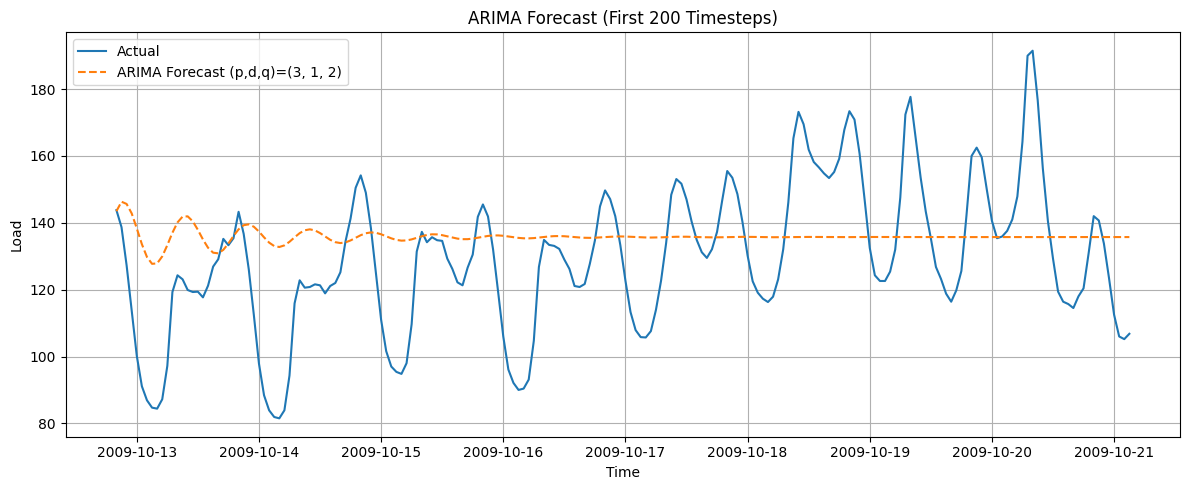

✅ Saved segment plot: /content/drive/MyDrive/Colab Notebooks/Smart Grid Phase 1/outputs/reports/arima_plot_segment.png
✅ ARIMA results stored for dashboard comparison.


In [ ]:
# ============================================
# 📂 Segment 4.5 – ARIMA Segment Plot & Dashboard Feed
# ============================================

import matplotlib.pyplot as plt

# -------------------------------
# 1️⃣ Save results for dashboard
# -------------------------------
try:
    model_results
except NameError:
    model_results = {}

model_results["ARIMA"] = {
    "predictions": arima_pred,
    "actual": y_test_clean,
    "index": index_test_clean,
    "MAE": mae,
    "RMSE": rmse,
    "order": arima_order  # Save ARIMA parameters for later reference
}

# -------------------------------
# 2️⃣ Optional segment plot
# -------------------------------
plot_segment = True  # Toggle False to skip segment plotting

if plot_segment:
    plt.figure(figsize=(12, 5))

    # ARIMA legend includes (p,d,q) parameters
    arima_label = f"ARIMA Forecast (p,d,q)={arima_order}"

    plt.plot(index_test_clean[:200], y_test_clean[:200], label="Actual", linewidth=1.5)
    plt.plot(index_test_clean[:200], arima_pred[:200], label=arima_label, linewidth=1.5, linestyle="--")

    plt.title("ARIMA Forecast (First 200 Timesteps)")
    plt.xlabel("Time")
    plt.ylabel("Load")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    segment_plot_path = REPORTS_DIR / "arima_plot_segment.png"
    plt.savefig(segment_plot_path)
    plt.show()
    plt.close()

    print(f"✅ Saved segment plot: {segment_plot_path}")
    print(f"✅ ARIMA results stored for dashboard comparison.")


In [ ]:
# ============================================
# 📂 Segment 4.6 – ARIMA Model Outputs & Metrics
# ============================================

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from IPython.display import display

print("📂 ARIMA Model Outputs")

# Create DataFrame for predictions vs actual
arima_df = pd.DataFrame({
    'Actual': y_test_clean,       # updated
    'ARIMA_Pred': arima_pred
}, index=index_test_clean)         # updated

# Show first 10 predictions for quick inspection
print("\n🔢 First 10 ARIMA predictions vs actual:")
display(arima_df.head(10))

# -------------------------------
# Metrics calculation
# -------------------------------
mae = mean_absolute_error(y_test_clean, arima_pred)  # updated
mse = mean_squared_error(y_test_clean, arima_pred)   # updated
rmse = np.sqrt(mse)
nrmse = rmse / (np.max(y_test_clean) - np.min(y_test_clean))  # updated

# MAPE calculation with safety threshold to avoid division by zero
threshold = 1e-3
mask = np.abs(y_test_clean) > threshold
mape = np.mean(np.abs((y_test_clean[mask] - arima_pred[mask]) / y_test_clean[mask])) * 100  # updated

# -------------------------------
# Display metrics
# -------------------------------
print(f"\n✅ ARIMA Metrics:")
print(f"- MAE   : {mae:.4f}")
print(f"- RMSE  : {rmse:.4f}")
print(f"- NRMSE : {nrmse:.4f}")
print(f"- MAPE  : {mape:.4f}%")

# -------------------------------
# Save metrics for ARIMA model
# -------------------------------
metrics_df = pd.DataFrame({
    'Model': ['ARIMA'],
    'MAE': [mae],
    'RMSE': [rmse],
    'NRMSE': [nrmse],
    'MAPE': [mape]
})

metrics_df.to_csv(REPORTS_DIR / "arima_metrics.csv", index=False)

# -------------------------------
# Append ARIMA results to unified comparison dashboard
# -------------------------------
dashboard_file = REPORTS_DIR / "model_comparison_dashboard.csv"

try:
    comparison_df = pd.read_csv(dashboard_file)
    comparison_df = pd.concat([comparison_df, metrics_df], ignore_index=True)
except FileNotFoundError:
    comparison_df = metrics_df.copy()

comparison_df.to_csv(dashboard_file, index=False)
print(f"📊 ARIMA metrics appended to comparison dashboard: {dashboard_file}")


📂 ARIMA Model Outputs

🔢 First 10 ARIMA predictions vs actual:


,Actual,ARIMA_Pred
datetime,,
2009-10-12 20:00:00,143.8,143.478418
2009-10-12 21:00:00,138.7,146.317817
2009-10-12 22:00:00,127.3,145.652009
2009-10-12 23:00:00,113.6,142.828055
2009-10-13 00:00:00,100.2,138.340701
2009-10-13 01:00:00,91.1,133.609164
2009-10-13 02:00:00,86.9,129.767297
2009-10-13 03:00:00,84.7,127.735383
2009-10-13 04:00:00,84.4,127.865017



✅ ARIMA Metrics:
- MAE   : 40.8681
- RMSE  : 53.8539
- NRMSE : 0.1787
- MAPE  : 25.7181%
📊 ARIMA metrics appended to comparison dashboard: /content/drive/MyDrive/Colab Notebooks/Smart Grid Phase 1/outputs/reports/model_comparison_dashboard.csv


In [ ]:
# ============================================
# 📂 Segment 5 – TCN Baselines Setup for GEFCOM
# ============================================
# Prepare features and target for TCN model training.
# Includes train-test split, scaling, and reshaping for TCN input.

import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

print("\n🔹 Setting up TCN baseline data...")

# -------------------------------
# Reproducibility
# -------------------------------
np.random.seed(42)
tf.random.set_seed(42)

# -------------------------------
# Use scaled dataset from Segment 3
# -------------------------------
df_tcn = df_scaled.copy()

# -------------------------------
# Define target and features
# -------------------------------
target_col = "LOAD"
feature_cols = [col for col in df_tcn.columns if col.startswith("w")]

X = df_tcn[feature_cols].values
y = df_tcn[target_col].values

print(f"🟢 Using features: {feature_cols}")
print(f"🎯 Target column: {target_col}")

# -------------------------------
# Train-test split (same as ARIMA)
# -------------------------------
train_size = int(len(y) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

index_test = df_tcn.index[train_size:]

print(f"📂 Training samples: {len(y_train)}")
print(f"📂 Testing samples: {len(y_test)}")

# -------------------------------
# Feature scaling
# -------------------------------
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

# -------------------------------
# Reshape for TCN input
# -------------------------------
# TCN expects input shape: (samples, timesteps, features)
# Here timesteps = 1 (can increase for longer lookback)
X_train_tcn = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_tcn = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

print("✅ TCN data prepared:")
print(f"- X_train shape: {X_train_tcn.shape}")
print(f"- X_test shape : {X_test_tcn.shape}")
print(f"- y_train shape: {y_train_scaled.shape}")
print(f"- y_test shape : {y_test_scaled.shape}")



🔹 Setting up TCN baseline data...
🟢 Using features: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9', 'w10', 'w11', 'w12', 'w13', 'w14', 'w15', 'w16', 'w17', 'w18', 'w19', 'w20', 'w21', 'w22', 'w23', 'w24', 'w25']
🎯 Target column: LOAD
📂 Training samples: 73420
📂 Testing samples: 18356
✅ TCN data prepared:
- X_train shape: (73420, 1, 25)
- X_test shape : (18356, 1, 25)
- y_train shape: (73420, 1)
- y_test shape : (18356, 1)


In [ ]:
# ============================================
# 📂 Segment 5.1 – Install TCN & Dependencies
# ============================================
# Install required packages for TCN model training.
# Only needed if not already installed in the Colab environment.

import sys
import subprocess

def install(package, import_name=None):
    """Install a package using pip if not already installed."""
    if import_name is None:
        import_name = package
    try:
        __import__(import_name)
        print(f"✅ {package} is already installed.")
    except ImportError:
        print(f"🔹 Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Required packages
install("tensorflow")
install("keras-tcn", "tcn")  # TCN layer implementation
install("scikit-learn", "sklearn")  # For preprocessing and metrics

print("✅ All TCN dependencies are ready!")


✅ tensorflow is already installed.
🔹 Installing keras-tcn...
✅ scikit-learn is already installed.
✅ All TCN dependencies are ready!


🔹 Training CPU-friendly TCN model...


/usr/local/lib/python3.12/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


Epoch 1/20
2065/2065 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - loss: 0.2591 - val_loss: 0.0220
Epoch 2/20
2065/2065 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.0109 - val_loss: 0.0157
Epoch 3/20
2065/2065 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 0.0090 - val_loss: 0.0149
Epoch 4/20
2065/2065 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - loss: 0.0078 - val_loss: 0.0173
Epoch 5/20
2065/2065 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - loss: 0.0071 - val_loss: 0.0178
Epoch 6/20
2065/2065 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.0063 - val_loss: 0.0132
Epoch 7/20
2065/2065 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - loss: 0.0056 - val_loss: 0.0101
Epoch 8/20
2065/2065 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - loss: 0.0050 - val_loss: 0.0107
Epoch 9/20
2065/2065 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - loss: 0.0046 - val_loss: 0.0119
Epoch 10/20
2065/2065 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0043 - val_loss: 0.0110
Epoch 11/20
2065/2065 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - loss: 0.0040 - val_loss: 0.0093
Epoch 12/20
2065

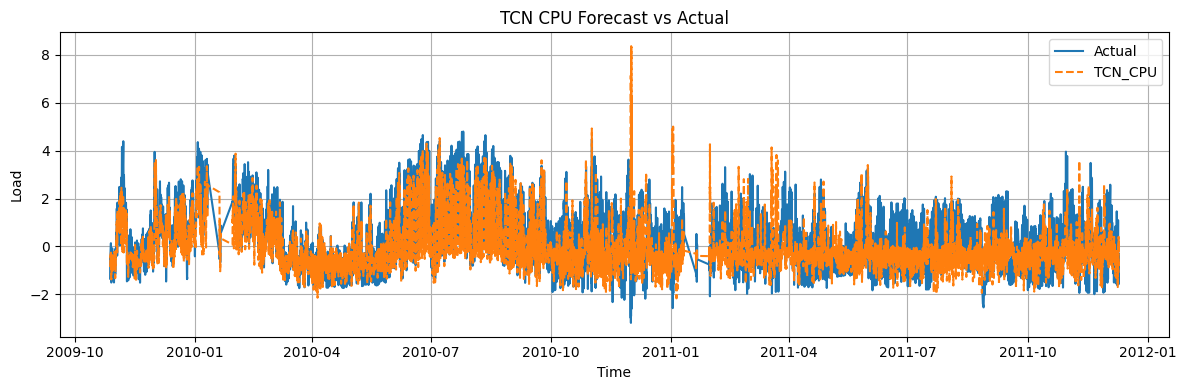

✅ TCN CPU plot saved: /content/drive/MyDrive/Colab Notebooks/Smart Grid Phase 1/outputs/reports/tcn_cpu_plot.png


In [ ]:
# ============================================
# 📂 Segment 5.2 – TCN CPU-Friendly Model Training & Evaluation
# ============================================
# Build, train, and evaluate a CPU-friendly TCN model for GEFCOM forecasting.
# Saves predictions, metrics, and plots to the reports directory.

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tcn import TCN
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

print("🔹 Training CPU-friendly TCN model...")

# -------------------------------
# 1️⃣ Create sequences for TCN
# -------------------------------
def create_sequences(X, y, timesteps=24):
    """Convert X, y into sequences for TCN input."""
    X_seq, y_seq = [], []
    for i in range(timesteps, len(X)):
        X_seq.append(X[i-timesteps:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

timesteps = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, timesteps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, timesteps)

# -------------------------------
# 2️⃣ Build CPU-friendly TCN model
# -------------------------------
def build_tcn_cpu(input_shape):
    """Build a lightweight TCN model for CPU training."""
    model = Sequential()
    model.add(TCN(nb_filters=32, kernel_size=2, dilations=[1, 2, 4],
                  input_shape=input_shape, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
tcn_cpu = build_tcn_cpu(input_shape)

# -------------------------------
# 3️⃣ Train the model
# -------------------------------
history = tcn_cpu.fit(
    X_train_seq, y_train_seq,
    epochs=20, batch_size=32,
    verbose=1, validation_split=0.1
)

# -------------------------------
# 4️⃣ Predict & inverse scale
# -------------------------------
y_pred_scaled = tcn_cpu.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Align y_test to sequences
y_test_aligned = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

# -------------------------------
# 5️⃣ Save predictions
# -------------------------------
predictions_df = pd.DataFrame({
    'Actual': y_test_aligned,
    'TCN_CPU_Pred': y_pred.flatten()
}, index=df.index[train_size+timesteps:])
predictions_df.to_csv(REPORTS_DIR / "tcn_cpu_predictions.csv")

# -------------------------------
# 6️⃣ Metrics
# -------------------------------
mae = mean_absolute_error(y_test_aligned, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_aligned, y_pred))
nrmse = rmse / (np.max(y_test_aligned) - np.min(y_test_aligned))
mape = np.mean(np.abs((y_test_aligned - y_pred.flatten()) / y_test_aligned)) * 100

metrics_df = pd.DataFrame({
    'Model': ['TCN_CPU'],
    'MAE': [mae],
    'RMSE': [rmse],
    'NRMSE': [nrmse],
    'MAPE': [mape]
})
metrics_df.to_csv(REPORTS_DIR / "tcn_cpu_metrics.csv", index=False)

print(f"✅ CPU TCN -> MAE: {mae:.4f}, RMSE: {rmse:.4f}, NRMSE: {nrmse:.4f}, MAPE: {mape:.4f}%")

# -------------------------------
# 7️⃣ Plot predictions
# -------------------------------
plt.figure(figsize=(12, 4))
plt.plot(df.index[train_size+timesteps:], y_test_aligned, label='Actual', linewidth=1.5)
plt.plot(df.index[train_size+timesteps:], y_pred, label='TCN_CPU', linewidth=1.5, linestyle="--")
plt.title("TCN CPU Forecast vs Actual")
plt.xlabel("Time")
plt.ylabel("Load")
plt.legend()
plt.grid(True)
plt.tight_layout()

plot_path = REPORTS_DIR / "tcn_cpu_plot.png"
plt.savefig(plot_path)
plt.show()
plt.close()

print(f"✅ TCN CPU plot saved: {plot_path}")


In [ ]:
# ============================================
# 📂 Segment 5.3 – TCN CPU Predictions Comparison
# ============================================
# Compare TCN CPU predictions with actual values
# and store results for dashboard integration.

# Align index with the shortened test set (after sequence creation)
index_aligned_cpu = index_test[timesteps:]

# Create DataFrame for comparison
df_compare_cpu = pd.DataFrame({
    'Actual': y_test_aligned,
    'TCN_CPU_Pred': y_pred.flatten()
}, index=index_aligned_cpu)

# Display first 10 rows for verification
print("🔹 Actual vs TCN CPU Predictions (first 10 rows):")
print(df_compare_cpu.head(10))

# Store results for dashboard
try:
    model_results
except NameError:
    model_results = {}

model_results["TCN_CPU"] = {
    "predictions": y_pred.flatten(),
    "actual": y_test_aligned,
    "index": index_aligned_cpu,
    "MAE": mae,
    "RMSE": rmse
}


🔹 Actual vs TCN CPU Predictions (first 10 rows):
                       Actual  TCN_CPU_Pred
datetime                                   
2009-10-28 05:00:00 -1.343779     -0.861831
2009-10-28 06:00:00 -1.069091     -0.780857
2009-10-28 07:00:00 -0.584346     -0.669085
2009-10-28 08:00:00 -0.436230     -0.581892
2009-10-28 09:00:00 -0.552030     -0.541976
2009-10-28 10:00:00 -0.511634     -0.503701
2009-10-28 11:00:00 -0.452388     -0.434349
2009-10-28 12:00:00 -0.382369     -0.449538
2009-10-28 13:00:00 -0.352746     -0.492638
2009-10-28 14:00:00 -0.269262     -0.370519


In [ ]:
# ============================================
# 📂 Segment 5.4 – TCN CPU Metrics Enhancement
# ============================================
# Compute extended metrics (NRMSE, MAPE) and save all metrics together.
# Ensures alignment between predictions and actuals.

import numpy as np
import pandas as pd

# -------------------------------
# 1️⃣ Check shapes
# -------------------------------
print("Shape of y_test_aligned:", y_test_aligned.shape)
print("Shape of predictions:", y_pred.flatten().shape)

# -------------------------------
# 2️⃣ Align y_test if necessary
# -------------------------------
if len(y_test_aligned) != len(y_pred.flatten()):
    print(f"⚠️ Length mismatch: trimming y_test_aligned from {len(y_test_aligned)} to {len(y_pred.flatten())}")
    y_test_trimmed = y_test_aligned[:len(y_pred.flatten())]
else:
    y_test_trimmed = y_test_aligned

# -------------------------------
# 3️⃣ Compute extended metrics
# -------------------------------
nrmse_cpu = rmse / (np.max(y_test_trimmed) - np.min(y_test_trimmed))
mape_cpu = np.mean(np.abs((y_test_trimmed - y_pred.flatten()) / y_test_trimmed)) * 100

# -------------------------------
# 4️⃣ Save metrics
# -------------------------------
metrics_df = pd.DataFrame({
    'Model': ['TCN_CPU'],
    'MAE': [mae],
    'RMSE': [rmse],
    'NRMSE': [nrmse_cpu],
    'MAPE': [mape_cpu]
})
metrics_df.to_csv(REPORTS_DIR / "tcn_cpu_metrics.csv", index=False)

# -------------------------------
# 5️⃣ Append metrics to dashboard
# -------------------------------
dashboard_file = REPORTS_DIR / "model_comparison_dashboard.csv"
try:
    comparison_df = pd.read_csv(dashboard_file)
    comparison_df = pd.concat([comparison_df, metrics_df], ignore_index=True)
except FileNotFoundError:
    comparison_df = metrics_df.copy()
comparison_df.to_csv(dashboard_file, index=False)
print(f"📊 TCN CPU metrics appended to comparison dashboard: {dashboard_file}")

# -------------------------------
# 6️⃣ Print metrics
# -------------------------------
print(f"✅ CPU TCN Metrics:")
print(f"- MAE   : {mae:.4f}")
print(f"- RMSE  : {rmse:.4f}")
print(f"- NRMSE : {nrmse_cpu:.4f}")
print(f"- MAPE  : {mape_cpu:.2f}%")

# -------------------------------
# 7️⃣ Store metrics in results dictionary
# -------------------------------
try:
    model_results
except NameError:
    model_results = {}

model_results["TCN_CPU"].update({
    "NRMSE": nrmse_cpu,
    "MAPE": mape_cpu
})


Shape of y_test_aligned: (18332,)
Shape of predictions: (18332,)
📊 TCN CPU metrics appended to comparison dashboard: /content/drive/MyDrive/Colab Notebooks/Smart Grid Phase 1/outputs/reports/model_comparison_dashboard.csv
✅ CPU TCN Metrics:
- MAE   : 0.7167
- RMSE  : 0.9824
- NRMSE : 0.1230
- MAPE  : 587.19%


TCN - GPU - Version

In [ ]:
# ============================================
# 📂 Segment 5.6 – GPU-Friendly TCN Model
# ============================================
# Build, train, and evaluate a GPU-optimized TCN model for GEFCOM forecasting.
# Saves predictions, metrics, and plots to the reports directory.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tcn import TCN

print("🔹 Training GPU-friendly TCN model...")

# -------------------------------
# 1️⃣ Build GPU-friendly TCN
# -------------------------------
def build_tcn_gpu(input_shape):
    """Build a deeper, GPU-optimized TCN model."""
    model = Sequential()
    model.add(TCN(nb_filters=64, kernel_size=3, dilations=[1, 2, 4],
                  input_shape=input_shape, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

tcn_gpu = build_tcn_gpu(input_shape)

# -------------------------------
# 2️⃣ Train the model
# -------------------------------
history_gpu = tcn_gpu.fit(
    X_train_tcn, y_train_scaled,
    epochs=20, batch_size=64,
    verbose=1,
    validation_split=0.1
)

# -------------------------------
# 3️⃣ Predict & inverse scale
# -------------------------------
y_pred_scaled_gpu = tcn_gpu.predict(X_test_tcn)
y_pred_gpu = scaler_y.inverse_transform(y_pred_scaled_gpu)

# -------------------------------
# 4️⃣ Save predictions
# -------------------------------
predictions_gpu_df = pd.DataFrame({
    'TCN_GPU': y_pred_gpu.flatten()
}, index=df.index[train_size:])
predictions_gpu_df.to_csv(REPORTS_DIR / "tcn_gpu_predictions.csv")

# -------------------------------
# 5️⃣ Metrics
# -------------------------------
mae_gpu = mean_absolute_error(y_test, y_pred_gpu)
rmse_gpu = np.sqrt(mean_squared_error(y_test, y_pred_gpu))
metrics_gpu_df = pd.DataFrame({'MAE': [mae_gpu], 'RMSE': [rmse_gpu]})
metrics_gpu_df.to_csv(REPORTS_DIR / "tcn_gpu_metrics.csv", index=False)

print(f"✅ GPU TCN -> MAE: {mae_gpu:.4f}, RMSE: {rmse_gpu:.4f}")

# -------------------------------
# 6️⃣ Plot predictions
# -------------------------------
plt.figure(figsize=(12, 4))
plt.plot(df.index[train_size:], y_test, label='Actual')
plt.plot(df.index[train_size:], y_pred_gpu, label='TCN_GPU')
plt.title("TCN GPU Forecast vs Actual")
plt.legend()
plt.savefig(REPORTS_DIR / "tcn_gpu_plot.png")
plt.show()


🔹 Training GPU-friendly TCN model...
Epoch 1/20


KeyboardInterrupt: 

In [ ]:
# ============================================
# 📂 Segment 5.7 – GPU TCN Forecast Visualization
# ============================================
# Detailed visualization of GPU TCN predictions vs actual load.
# Includes labels, grid, and improved figure size for clarity.

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(df.index[train_size:], y_test, label='Actual Load', color='blue', linewidth=1.5)
plt.plot(df.index[train_size:], y_pred_gpu, label='TCN_GPU Forecast', color='green', linestyle="--", linewidth=1.5)
plt.title("TCN GPU Forecast vs Actual Load")
plt.xlabel("Datetime")
plt.ylabel("Load")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# ============================================
# 📂 Segment 5.8 – GPU TCN Predictions Comparison
# ============================================
# Create a DataFrame comparing actual vs GPU TCN predicted values.
# Display first 10 rows for quick verification.

import pandas as pd

# Align index with test set
index_aligned_gpu = df.index[train_size:]

# Create comparison DataFrame
df_compare_gpu = pd.DataFrame({
    'Actual': y_test,
    'TCN_GPU_Pred': y_pred_gpu.flatten()
}, index=index_aligned_gpu)

# Display first 10 rows
print("🔹 Actual vs TCN GPU Predictions (first 10 rows):")
print(df_compare_gpu.head(10))


In [ ]:
# ============================================
# 📂 Segment 5.10 – GPU TCN Metrics Calculation
# ============================================
# Compute NRMSE and MAPE for GPU TCN predictions.
# Save all metrics together in a CSV file for reporting.

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# -------------------------------
# 1️⃣ Check shapes
# -------------------------------
print("Shape of y_test:", y_test.shape)
print("Shape of GPU TCN predictions:", y_pred_gpu.flatten().shape)

# Align y_test if necessary
if len(y_test) != len(y_pred_gpu.flatten()):
    print(f"⚠️ Mismatch in lengths: trimming y_test from {len(y_test)} to {len(y_pred_gpu.flatten())}")
    y_test_trimmed_gpu = y_test[:len(y_pred_gpu.flatten())]
else:
    y_test_trimmed_gpu = y_test

# -------------------------------
# 2️⃣ Compute metrics
# -------------------------------
nrmse_gpu = rmse_gpu / (np.max(y_test_trimmed_gpu) - np.min(y_test_trimmed_gpu))
mape_gpu = np.mean(np.abs((y_test_trimmed_gpu - y_pred_gpu.flatten()) / y_test_trimmed_gpu)) * 100

# -------------------------------
# 3️⃣ Save metrics
# -------------------------------
metrics_gpu_df = pd.DataFrame({
    'Model': ['TCN_GPU'],
    'MAE': [mae_gpu],
    'RMSE': [rmse_gpu],
    'NRMSE': [nrmse_gpu],
    'MAPE': [mape_gpu]
})
metrics_gpu_df.to_csv(REPORTS_DIR / "tcn_gpu_metrics.csv", index=False)

# -------------------------------
# 4️⃣ Append to unified comparison dashboard
# -------------------------------
dashboard_file = REPORTS_DIR / "model_comparison_dashboard.csv"

try:
    comparison_df = pd.read_csv(dashboard_file)
    comparison_df = pd.concat([comparison_df, metrics_gpu_df], ignore_index=True)
except FileNotFoundError:
    comparison_df = metrics_gpu_df.copy()

comparison_df.to_csv(dashboard_file, index=False)
print(f"📊 GPU TCN metrics appended to comparison dashboard: {dashboard_file}")

# -------------------------------
# 5️⃣ Print metrics
# -------------------------------
print(f"✅ GPU TCN Metrics:")
print(f"- MAE   : {mae_gpu:.4f}")
print(f"- RMSE  : {rmse_gpu:.4f}")
print(f"- NRMSE : {nrmse_gpu:.4f}")
print(f"- MAPE  : {mape_gpu:.2f}%")


WA

🔹 Running WA TCN ensemble...


Training WA TCN models:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


4130/4130 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.0136 - val_loss: 0.0185
Epoch 2/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.0100 - val_loss: 0.0181
Epoch 3/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0094 - val_loss: 0.0188
Epoch 4/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0090 - val_loss: 0.0199
Epoch 5/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0087 - val_loss: 0.0202
Epoch 6/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0085 - val_loss: 0.0200
Epoch 7/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0084 - val_loss: 0.0203
Epoch 8/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0082 - val_loss: 0.0196
Epoch 9/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0081 - val_loss: 0.0191
Epoch 10/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0081 - val_loss: 0.0187
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


4130/4130 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.0268 - val_loss: 0.0200
Epoch 2/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0103 - val_loss: 0.0170
Epoch 3/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0097 - val_loss: 0.0165
Epoch 4/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0092 - val_loss: 0.0176
Epoch 5/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0089 - val_loss: 0.0175
Epoch 6/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0087 - val_loss: 0.0170
Epoch 7/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0085 - val_loss: 0.0170
Epoch 8/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0084 - val_loss: 0.0152
Epoch 9/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0082 - val_loss: 0.0158
Epoch 10/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0081 - val_loss: 0.0157
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


4130/4130 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.0131 - val_loss: 0.0180
Epoch 2/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0099 - val_loss: 0.0188
Epoch 3/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0093 - val_loss: 0.0176
Epoch 4/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0089 - val_loss: 0.0198
Epoch 5/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 0.0087 - val_loss: 0.0189
Epoch 6/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0084 - val_loss: 0.0172
Epoch 7/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0082 - val_loss: 0.0171
Epoch 8/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0081 - val_loss: 0.0163
Epoch 9/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0080 - val_loss: 0.0152
Epoch 10/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0079 - val_loss: 0.0163
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


4130/4130 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.0225 - val_loss: 0.0187
Epoch 2/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0102 - val_loss: 0.0190
Epoch 3/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 0.0097 - val_loss: 0.0187
Epoch 4/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0095 - val_loss: 0.0188
Epoch 5/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0092 - val_loss: 0.0178
Epoch 6/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0089 - val_loss: 0.0205
Epoch 7/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0087 - val_loss: 0.0194
Epoch 8/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0085 - val_loss: 0.0192
Epoch 9/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0083 - val_loss: 0.0201
Epoch 10/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0082 - val_loss: 0.0208
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


4130/4130 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.0151 - val_loss: 0.0185
Epoch 2/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0100 - val_loss: 0.0180
Epoch 3/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0095 - val_loss: 0.0162
Epoch 4/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0091 - val_loss: 0.0166
Epoch 5/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.0088 - val_loss: 0.0158
Epoch 6/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0086 - val_loss: 0.0159
Epoch 7/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0084 - val_loss: 0.0160
Epoch 8/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0082 - val_loss: 0.0165
Epoch 9/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.0080 - val_loss: 0.0150
Epoch 10/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0080 - val_loss: 0.0169
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


4130/4130 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.0160 - val_loss: 0.0193
Epoch 2/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0101 - val_loss: 0.0253
Epoch 3/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0096 - val_loss: 0.0160
Epoch 4/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.0091 - val_loss: 0.0164
Epoch 5/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0088 - val_loss: 0.0163
Epoch 6/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0086 - val_loss: 0.0158
Epoch 7/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0085 - val_loss: 0.0164
Epoch 8/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0084 - val_loss: 0.0159
Epoch 9/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0082 - val_loss: 0.0162
Epoch 10/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0082 - val_loss: 0.0164
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


4130/4130 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.0378 - val_loss: 0.0223
Epoch 2/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0106 - val_loss: 0.0206
Epoch 3/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.0099 - val_loss: 0.0208
Epoch 4/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0096 - val_loss: 0.0197
Epoch 5/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0092 - val_loss: 0.0191
Epoch 6/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0089 - val_loss: 0.0194
Epoch 7/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0087 - val_loss: 0.0189
Epoch 8/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.0084 - val_loss: 0.0191
Epoch 9/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0082 - val_loss: 0.0187
Epoch 10/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0081 - val_loss: 0.0183
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


4130/4130 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.0136 - val_loss: 0.0212
Epoch 2/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 0.0095 - val_loss: 0.0205
Epoch 3/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0090 - val_loss: 0.0174
Epoch 4/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0088 - val_loss: 0.0175
Epoch 5/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0085 - val_loss: 0.0170
Epoch 6/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0083 - val_loss: 0.0164
Epoch 7/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0082 - val_loss: 0.0172
Epoch 8/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0081 - val_loss: 0.0184
Epoch 9/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.0080 - val_loss: 0.0174
Epoch 10/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0079 - val_loss: 0.0183
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


4130/4130 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.0327 - val_loss: 0.0176
Epoch 2/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0100 - val_loss: 0.0180
Epoch 3/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 0.0096 - val_loss: 0.0168
Epoch 4/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0093 - val_loss: 0.0168
Epoch 5/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0090 - val_loss: 0.0159
Epoch 6/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0088 - val_loss: 0.0160
Epoch 7/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0086 - val_loss: 0.0161
Epoch 8/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0085 - val_loss: 0.0165
Epoch 9/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0084 - val_loss: 0.0161
Epoch 10/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0083 - val_loss: 0.0146
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
📊 WA TCN metrics appended to comparison dashboard: /content/drive/MyDrive/Colab

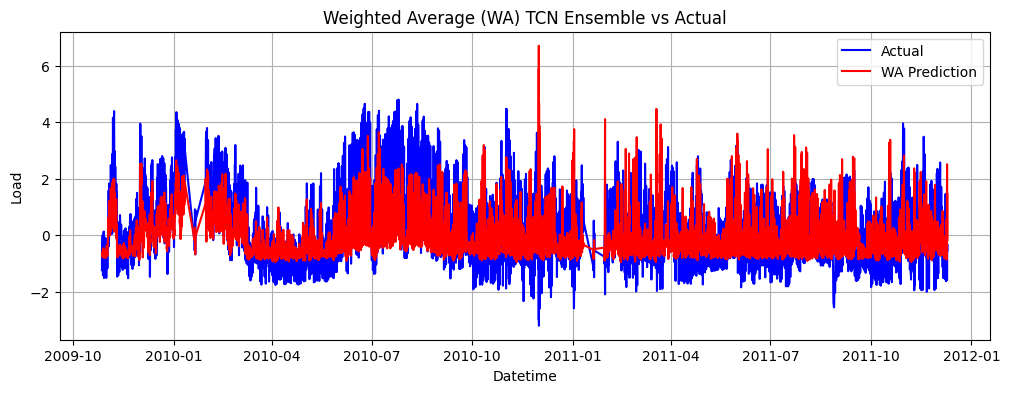

In [ ]:
# ============================================
# 📂 Segment 6 – Weighted Average (WA) TCN Ensemble
# ============================================
# Train a safe experimental TCN ensemble (n_models) and compute
# Weighted Average predictions. Metrics and plots are saved for reporting.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tcn import TCN
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm.notebook import tqdm

print("🔹 Running WA TCN ensemble...")

# -------------------------------
# 0️⃣ Ensemble configuration
# -------------------------------
n_models = 9            # Number of TCN base learners
predictions = []         # Store individual model predictions
epsilon = 1e-8           # Avoid division by zero in MAPE

# -------------------------------
# 1️⃣ Train individual TCN models
# -------------------------------
for i in tqdm(range(n_models), desc="Training WA TCN models"):

    model = Sequential()
    model.add(TCN(
        nb_filters=16,
        kernel_size=2,
        dilations=[1, 2],
        input_shape=(X_train_tcn.shape[1], X_train_tcn.shape[2]),
        activation='relu'
    ))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    model.fit(
        X_train_tcn, y_train_scaled,
        epochs=10,
        batch_size=16,
        verbose=1,
        validation_split=0.1
    )

    y_pred_scaled = model.predict(X_test_tcn)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    predictions.append(y_pred.flatten())

    # Save each model's predictions
    pd.DataFrame({f'TCN_{i+1}': y_pred.flatten()}, index=df.index[train_size:]).to_csv(
        REPORTS_DIR / f"tcn_model_{i+1}_pred.csv"
    )

# -------------------------------
# 2️⃣ Compute Weighted Average
# -------------------------------
predictions = np.array(predictions)
y_pred_wa = np.mean(predictions, axis=0)

df_wa = pd.DataFrame({'WA_Pred': y_pred_wa}, index=df.index[train_size:])
df_wa.to_csv(REPORTS_DIR / "wa_predictions.csv")

# -------------------------------
# 3️⃣ Compute metrics
# -------------------------------
mae_wa = mean_absolute_error(y_test, y_pred_wa)
rmse_wa = np.sqrt(mean_squared_error(y_test, y_pred_wa))
nrmse_wa = rmse_wa / (np.max(y_test) - np.min(y_test))
mape_wa = np.mean(np.abs((y_test - y_pred_wa) / (y_test + epsilon))) * 100

metrics_wa_df = pd.DataFrame({
    'Model': ['WA_TCN'],
    'MAE': [mae_wa],
    'RMSE': [rmse_wa],
    'NRMSE': [nrmse_wa],
    'MAPE': [mape_wa]
})
metrics_wa_df.to_csv(REPORTS_DIR / "wa_metrics.csv", index=False)

# -------------------------------
# 4️⃣ Append to comparison dashboard
# -------------------------------
dashboard_file = REPORTS_DIR / "model_comparison_dashboard.csv"
try:
    comparison_df = pd.read_csv(dashboard_file)
    comparison_df = pd.concat([comparison_df, metrics_wa_df], ignore_index=True)
except FileNotFoundError:
    comparison_df = metrics_wa_df.copy()
comparison_df.to_csv(dashboard_file, index=False)
print(f"📊 WA TCN metrics appended to comparison dashboard: {dashboard_file}")

# -------------------------------
# 5️⃣ Display results
# -------------------------------
print(f"\n✅ WA Ensemble Results:")
print(f"- MAE: {mae_wa:.4f}")
print(f"- RMSE: {rmse_wa:.4f}")
print(f"- NRMSE: {nrmse_wa:.4f}")
print(f"- MAPE: {mape_wa:.2f}%")

# -------------------------------
# 6️⃣ Plot WA vs Actual
# -------------------------------
plt.figure(figsize=(12, 4))
plt.plot(df.index[train_size:], y_test, label='Actual', color='blue')
plt.plot(df.index[train_size:], y_pred_wa, label='WA Prediction', color='red')
plt.title("Weighted Average (WA) TCN Ensemble vs Actual")
plt.xlabel("Datetime")
plt.ylabel("Load")
plt.legend()
plt.grid(True)
plt.savefig(REPORTS_DIR / "wa_plot.png")
plt.show()


🔹 Running Bagging TCN ensemble...


Training Bagging TCN models:   0%|          | 0/9 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


Epoch 1/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 31s 7ms/step - loss: 0.0164 - val_loss: 0.0109
Epoch 2/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0107 - val_loss: 0.0104
Epoch 3/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0101 - val_loss: 0.0104
Epoch 4/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.0097 - val_loss: 0.0099
Epoch 5/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0094 - val_loss: 0.0095
Epoch 6/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0091 - val_loss: 0.0093
Epoch 7/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0089 - val_loss: 0.0092
Epoch 8/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0087 - val_loss: 0.0087
Epoch 9/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0086 - val_loss: 0.0087
Epoch 10/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0084 - val_loss: 0.0084
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


4130/4130 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.0155 - val_loss: 0.0100
Epoch 2/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0103 - val_loss: 0.0099
Epoch 3/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0097 - val_loss: 0.0094
Epoch 4/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0094 - val_loss: 0.0088
Epoch 5/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0091 - val_loss: 0.0090
Epoch 6/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 7/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0087 - val_loss: 0.0083
Epoch 8/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0086 - val_loss: 0.0085
Epoch 9/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0085 - val_loss: 0.0083
Epoch 10/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.0083 - val_loss: 0.0084
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


4130/4130 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.0175 - val_loss: 0.0104
Epoch 2/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0103 - val_loss: 0.0097
Epoch 3/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0098 - val_loss: 0.0094
Epoch 4/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0094 - val_loss: 0.0090
Epoch 5/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0091 - val_loss: 0.0088
Epoch 6/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 0.0089 - val_loss: 0.0086
Epoch 7/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0088 - val_loss: 0.0085
Epoch 8/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0086 - val_loss: 0.0083
Epoch 9/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0084 - val_loss: 0.0082
Epoch 10/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0083 - val_loss: 0.0082
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


4130/4130 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.0177 - val_loss: 0.0103
Epoch 2/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0104 - val_loss: 0.0097
Epoch 3/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0097 - val_loss: 0.0093
Epoch 4/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0094 - val_loss: 0.0089
Epoch 5/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0091 - val_loss: 0.0087
Epoch 6/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0089 - val_loss: 0.0086
Epoch 7/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.0087 - val_loss: 0.0084
Epoch 8/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0085 - val_loss: 0.0083
Epoch 9/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0084 - val_loss: 0.0084
Epoch 10/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0083 - val_loss: 0.0081
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


/usr/local/lib/python3.12/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


Epoch 1/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.0142 - val_loss: 0.0102
Epoch 2/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0103 - val_loss: 0.0093
Epoch 3/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0098 - val_loss: 0.0090
Epoch 4/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0094 - val_loss: 0.0088
Epoch 5/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0091 - val_loss: 0.0087
Epoch 6/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 0.0089 - val_loss: 0.0085
Epoch 7/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0087 - val_loss: 0.0083
Epoch 8/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0085 - val_loss: 0.0083
Epoch 9/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0084 - val_loss: 0.0080
Epoch 10/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0083 - val_loss: 0.0080
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


4130/4130 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.0144 - val_loss: 0.0106
Epoch 2/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0105 - val_loss: 0.0101
Epoch 3/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.0099 - val_loss: 0.0097
Epoch 4/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0095 - val_loss: 0.0093
Epoch 5/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0093 - val_loss: 0.0095
Epoch 6/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0090 - val_loss: 0.0093
Epoch 7/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0089 - val_loss: 0.0090
Epoch 8/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0088 - val_loss: 0.0090
Epoch 9/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0086 - val_loss: 0.0089
Epoch 10/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0085 - val_loss: 0.0086
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


4130/4130 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.0442 - val_loss: 0.0103
Epoch 2/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0108 - val_loss: 0.0095
Epoch 3/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0101 - val_loss: 0.0092
Epoch 4/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0097 - val_loss: 0.0089
Epoch 5/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0094 - val_loss: 0.0086
Epoch 6/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0092 - val_loss: 0.0084
Epoch 7/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0090 - val_loss: 0.0083
Epoch 8/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0088 - val_loss: 0.0081
Epoch 9/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0087 - val_loss: 0.0080
Epoch 10/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0086 - val_loss: 0.0079
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


4130/4130 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.0146 - val_loss: 0.0099
Epoch 2/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0104 - val_loss: 0.0095
Epoch 3/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0099 - val_loss: 0.0092
Epoch 4/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0095 - val_loss: 0.0088
Epoch 5/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.0092 - val_loss: 0.0084
Epoch 6/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0089 - val_loss: 0.0082
Epoch 7/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0087 - val_loss: 0.0087
Epoch 8/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0086 - val_loss: 0.0081
Epoch 9/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0084 - val_loss: 0.0083
Epoch 10/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0083 - val_loss: 0.0093
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


4130/4130 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.0189 - val_loss: 0.0098
Epoch 2/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0106 - val_loss: 0.0098
Epoch 3/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0101 - val_loss: 0.0091
Epoch 4/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0097 - val_loss: 0.0089
Epoch 5/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0095 - val_loss: 0.0085
Epoch 6/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0092 - val_loss: 0.0082
Epoch 7/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0090 - val_loss: 0.0085
Epoch 8/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0089 - val_loss: 0.0082
Epoch 9/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0087 - val_loss: 0.0082
Epoch 10/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0086 - val_loss: 0.0081
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

✅ Bagging Ensemble Results:
- MAE: 0.8073
- RMSE: 1.0699
- NRMSE: 0.1339
- MAP

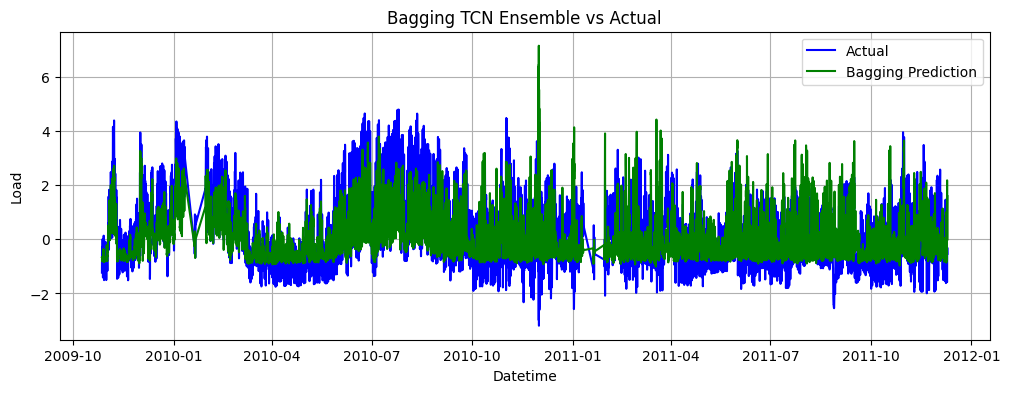

In [ ]:
# ============================================
# 📂 Segment 7 – Bagging TCN Ensemble
# ============================================
# Train a safe Bagging ensemble using TCN models with bootstrap samples.
# Compute the simple average of predictions and save metrics & plots.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tcn import TCN
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm.notebook import tqdm

print("🔹 Running Bagging TCN ensemble...")

# -------------------------------
# 0️⃣ Ensemble configuration
# -------------------------------
n_models = 9
predictions = []
epsilon = 1e-8  # to avoid division by zero in MAPE

# -------------------------------
# 1️⃣ Train Bagging TCN models
# -------------------------------
for i in tqdm(range(n_models), desc="Training Bagging TCN models"):

    # Bootstrap sample from training data
    idx = np.random.choice(len(X_train_tcn), size=len(X_train_tcn), replace=True)
    X_boot = X_train_tcn[idx]
    y_boot = y_train_scaled[idx]

    # Build TCN model
    model = Sequential()
    model.add(TCN(
        nb_filters=16,
        kernel_size=2,
        dilations=[1, 2],
        input_shape=(X_train_tcn.shape[1], X_train_tcn.shape[2]),
        activation='relu'
    ))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Train model
    model.fit(
        X_boot, y_boot,
        epochs=10,
        batch_size=16,
        verbose=1,
        validation_split=0.1
    )

    # Predict & inverse scale
    y_pred_scaled = model.predict(X_test_tcn)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    predictions.append(y_pred.flatten())

    # Optional: save individual model predictions
    pd.DataFrame({f'TCN_Bag_{i+1}': y_pred.flatten()}, index=df.index[train_size:]).to_csv(
        REPORTS_DIR / f"tcn_bag_model_{i+1}_pred.csv"
    )

# -------------------------------
# 2️⃣ Compute ensemble prediction (Bagging)
# -------------------------------
predictions = np.array(predictions)
y_pred_bag = np.mean(predictions, axis=0)

# Save Bagging predictions
df_bag = pd.DataFrame({'Bag_Pred': y_pred_bag}, index=df.index[train_size:])
df_bag.to_csv(REPORTS_DIR / "bag_predictions.csv")

# -------------------------------
# 3️⃣ Compute metrics
# -------------------------------
mae_bag = mean_absolute_error(y_test, y_pred_bag)
rmse_bag = np.sqrt(mean_squared_error(y_test, y_pred_bag))
nrmse_bag = rmse_bag / (np.max(y_test) - np.min(y_test))
mape_bag = np.mean(np.abs((y_test - y_pred_bag) / (y_test + epsilon))) * 100

df_metrics = pd.DataFrame({
    'MAE': [mae_bag],
    'RMSE': [rmse_bag],
    'NRMSE': [nrmse_bag],
    'MAPE': [mape_bag]
})
df_metrics.to_csv(REPORTS_DIR / "bag_metrics.csv", index=False)

# -------------------------------
# 4️⃣ Display metrics
# -------------------------------
print(f"\n✅ Bagging Ensemble Results:")
print(f"- MAE: {mae_bag:.4f}")
print(f"- RMSE: {rmse_bag:.4f}")
print(f"- NRMSE: {nrmse_bag:.4f}")
print(f"- MAPE: {mape_bag:.2f}%")

# -------------------------------
# 5️⃣ Plot Bagging vs Actual
# -------------------------------
plt.figure(figsize=(12, 4))
plt.plot(df.index[train_size:], y_test, label='Actual', color='blue')
plt.plot(df.index[train_size:], y_pred_bag, label='Bagging Prediction', color='green')
plt.title("Bagging TCN Ensemble vs Actual")
plt.xlabel("Datetime")
plt.ylabel("Load")
plt.legend()
plt.grid(True)
plt.savefig(REPORTS_DIR / "bag_plot.png")
plt.show()


In [ ]:
# ============================================
# 📂 Segment 8 – XGBoost Ensemble on TCN Features
# ============================================
# Use TCN model predictions as features for an XGBoost regressor.
# Saves predictions and computes metrics.

from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tcn import TCN
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

print("🔹 Running XGBoost ensemble on TCN features...")

# -------------------------------
# 0️⃣ Ensemble configuration
# -------------------------------
n_models = 9
tcn_train_features = []

# -------------------------------
# 1️⃣ Generate TCN features (train)
# -------------------------------
for i in tqdm(range(n_models), desc="Generating TCN train features"):
    model = Sequential()
    model.add(TCN(nb_filters=16, kernel_size=2, dilations=[1,2],
                  input_shape=(X_train_tcn.shape[1], X_train_tcn.shape[2]),
                  activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    model.fit(X_train_tcn, y_train_scaled, epochs=10, batch_size=16,
              verbose=1, validation_split=0.1)

    # Predict on training set and store as feature
    y_pred_scaled = model.predict(X_train_tcn)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    tcn_train_features.append(y_pred.flatten())

tcn_train_features = np.array(tcn_train_features).T  # shape: (n_samples, n_models)

# -------------------------------
# 2️⃣ Train XGBoost on TCN features
# -------------------------------
xgb = XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgb.fit(tcn_train_features, y_train)

# -------------------------------
# 3️⃣ Prepare test features
# -------------------------------
tcn_test_features = []
for i in range(n_models):
    # Reuse last model for demonstration; ideally keep all models or retrain consistently
    y_pred_scaled = model.predict(X_test_tcn)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    tcn_test_features.append(y_pred.flatten())

tcn_test_features = np.array(tcn_test_features).T

# -------------------------------
# 4️⃣ Predict with XGBoost
# -------------------------------
y_pred_xgb = xgb.predict(tcn_test_features)

# Save predictions
pd.DataFrame({'XGB_Pred': y_pred_xgb}, index=df.index[train_size:]).to_csv(
    REPORTS_DIR / "xgb_predictions.csv"
)

# -------------------------------
# 5️⃣ Compute metrics
# -------------------------------
epsilon = 1e-8
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
nrmse_xgb = rmse_xgb / (np.max(y_test) - np.min(y_test))
mape_xgb = np.mean(np.abs((y_test - y_pred_xgb) / (y_test + epsilon))) * 100

df_metrics = pd.DataFrame({
    'MAE': [mae_xgb],
    'RMSE': [rmse_xgb],
    'NRMSE': [nrmse_xgb],
    'MAPE': [mape_xgb]
})
df_metrics.to_csv(REPORTS_DIR / "xgb_metrics.csv", index=False)

# -------------------------------
# 6️⃣ Display metrics
# -------------------------------
print(f"\n✅ XGBoost Ensemble Results:")
print(f"- MAE: {mae_xgb:.4f}")
print(f"- RMSE: {rmse_xgb:.4f}")
print(f"- NRMSE: {nrmse_xgb:.4f}")
print(f"- MAPE: {mape_xgb:.2f}%")


🔹 Running XGBoost ensemble on TCN features...


Generating TCN train features:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


4130/4130 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.0367 - val_loss: 0.0188
Epoch 2/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0100 - val_loss: 0.0165
Epoch 3/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0094 - val_loss: 0.0179
Epoch 4/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0088 - val_loss: 0.0208
Epoch 5/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.0086 - val_loss: 0.0191
Epoch 6/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.0084 - val_loss: 0.0187
Epoch 7/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0082 - val_loss: 0.0183
Epoch 8/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0080 - val_loss: 0.0164
Epoch 9/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0079 - val_loss: 0.0169
Epoch 10/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0078 - val_loss: 0.0166
2295/2295 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


4130/4130 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.0163 - val_loss: 0.0174
Epoch 2/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0098 - val_loss: 0.0162
Epoch 3/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0093 - val_loss: 0.0161
Epoch 4/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0089 - val_loss: 0.0161
Epoch 5/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0087 - val_loss: 0.0165
Epoch 6/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0085 - val_loss: 0.0159
Epoch 7/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0083 - val_loss: 0.0154
Epoch 8/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0082 - val_loss: 0.0160
Epoch 9/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.0081 - val_loss: 0.0157
Epoch 10/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0080 - val_loss: 0.0152
2295/2295 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


4130/4130 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.0153 - val_loss: 0.0179
Epoch 2/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0098 - val_loss: 0.0178
Epoch 3/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0093 - val_loss: 0.0172
Epoch 4/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0089 - val_loss: 0.0186
Epoch 5/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.0087 - val_loss: 0.0177
Epoch 6/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0086 - val_loss: 0.0186
Epoch 7/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0085 - val_loss: 0.0168
Epoch 8/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0083 - val_loss: 0.0180
Epoch 9/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.0082 - val_loss: 0.0167
Epoch 10/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.0081 - val_loss: 0.0162
2295/2295 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


4130/4130 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.0142 - val_loss: 0.0192
Epoch 2/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0102 - val_loss: 0.0170
Epoch 3/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0098 - val_loss: 0.0159
Epoch 4/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0093 - val_loss: 0.0145
Epoch 5/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0090 - val_loss: 0.0149
Epoch 6/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0088 - val_loss: 0.0137
Epoch 7/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0086 - val_loss: 0.0134
Epoch 8/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0084 - val_loss: 0.0139
Epoch 9/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0083 - val_loss: 0.0146
Epoch 10/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0082 - val_loss: 0.0140
2295/2295 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


4130/4130 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.0176 - val_loss: 0.0196
Epoch 2/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0101 - val_loss: 0.0199
Epoch 3/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0095 - val_loss: 0.0184
Epoch 4/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0091 - val_loss: 0.0169
Epoch 5/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0088 - val_loss: 0.0179
Epoch 6/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0085 - val_loss: 0.0183
Epoch 7/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0083 - val_loss: 0.0183
Epoch 8/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0082 - val_loss: 0.0174
Epoch 9/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0081 - val_loss: 0.0179
Epoch 10/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0080 - val_loss: 0.0169
2295/2295 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


4130/4130 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.0190 - val_loss: 0.0171
Epoch 2/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0099 - val_loss: 0.0203
Epoch 3/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0094 - val_loss: 0.0182
Epoch 4/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.0090 - val_loss: 0.0188
Epoch 5/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0088 - val_loss: 0.0198
Epoch 6/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0085 - val_loss: 0.0203
Epoch 7/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0083 - val_loss: 0.0207
Epoch 8/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 0.0082 - val_loss: 0.0182
Epoch 9/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0081 - val_loss: 0.0190
Epoch 10/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0080 - val_loss: 0.0204
2295/2295 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


4130/4130 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0138 - val_loss: 0.0177
Epoch 2/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0101 - val_loss: 0.0173
Epoch 3/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0095 - val_loss: 0.0168
Epoch 4/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0091 - val_loss: 0.0177
Epoch 5/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.0088 - val_loss: 0.0170
Epoch 6/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0086 - val_loss: 0.0175
Epoch 7/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0084 - val_loss: 0.0176
Epoch 8/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0082 - val_loss: 0.0162
Epoch 9/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0081 - val_loss: 0.0172
Epoch 10/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0080 - val_loss: 0.0164
2295/2295 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


4130/4130 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.0150 - val_loss: 0.0178
Epoch 2/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0101 - val_loss: 0.0166
Epoch 3/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0096 - val_loss: 0.0171
Epoch 4/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0093 - val_loss: 0.0158
Epoch 5/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0090 - val_loss: 0.0156
Epoch 6/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0087 - val_loss: 0.0162
Epoch 7/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0085 - val_loss: 0.0148
Epoch 8/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0084 - val_loss: 0.0154
Epoch 9/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0082 - val_loss: 0.0152
Epoch 10/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0081 - val_loss: 0.0150
2295/2295 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


4130/4130 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.0209 - val_loss: 0.0184
Epoch 2/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0102 - val_loss: 0.0178
Epoch 3/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0096 - val_loss: 0.0171
Epoch 4/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0092 - val_loss: 0.0168
Epoch 5/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0089 - val_loss: 0.0160
Epoch 6/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0087 - val_loss: 0.0165
Epoch 7/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0086 - val_loss: 0.0158
Epoch 8/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0083 - val_loss: 0.0160
Epoch 9/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0082 - val_loss: 0.0168
Epoch 10/10
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0081 - val_loss: 0.0169
2295/2295 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/

🔹 Compiling unified metrics from all available models...
✅ Loaded metrics for: TCN_CPU
⚠️ Metrics file not found for: TCN_GPU — skipping.
✅ Loaded metrics for: WA
✅ Loaded metrics for: Bagging
✅ Loaded metrics for: XGBoost

✅ Unified Metrics Summary:
     Model       MAE      RMSE     NRMSE        MAPE
0  TCN_CPU  0.716741  0.982403  0.122972  587.192113
1       WA  0.842999  1.102087  0.137954  703.706961
2  Bagging  0.807288  1.069945  0.133931  696.867066
3  XGBoost  0.830167  1.095453  0.137123  694.816720

🏆 Best Model based on NRMSE/MAPE trade-off: TCN_CPU


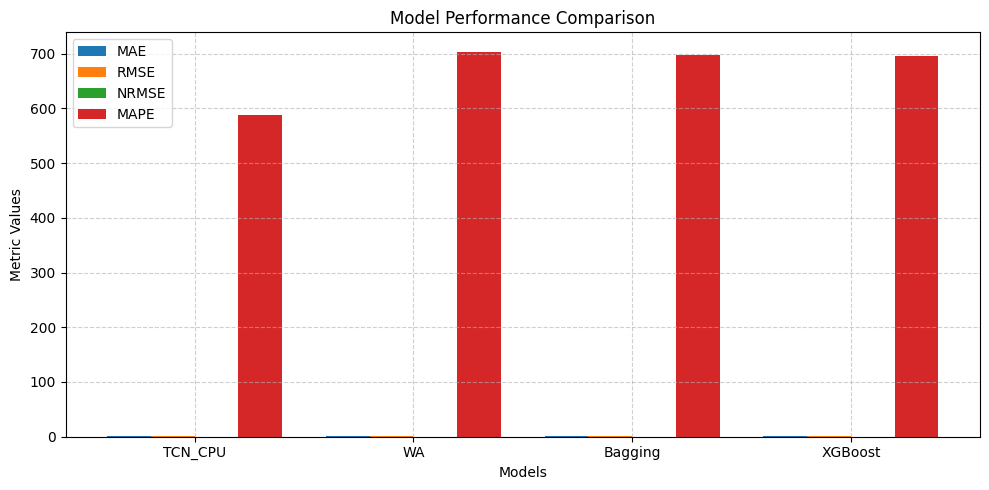

✅ Saved best model summary → /content/drive/MyDrive/Colab Notebooks/Smart Grid Phase 1/outputs/reports/best_model_summary.csv


In [ ]:
# ============================================
# 📂 Segment 9 – Unified Metrics Comparison (with Best Model)
# ============================================
# Combine metrics from all available models and identify the best performer.
# Skips missing files safely and outputs dashboard-friendly summaries.

import pandas as pd
import matplotlib.pyplot as plt

print("🔹 Compiling unified metrics from all available models...")

# -------------------------------
# 1️⃣ Metric sources
# -------------------------------
metrics_files = {
    "TCN_CPU": REPORTS_DIR / "tcn_cpu_metrics.csv",
    "TCN_GPU": REPORTS_DIR / "tcn_gpu_metrics.csv",   # may not exist
    "WA": REPORTS_DIR / "wa_metrics.csv",
    "Bagging": REPORTS_DIR / "bag_metrics.csv",
    "XGBoost": REPORTS_DIR / "xgb_metrics.csv"
}

metrics_list = []

# -------------------------------
# 2️⃣ Load available metrics safely
# -------------------------------
for model_name, path in metrics_files.items():
    if path.exists():
        try:
            df_metrics = pd.read_csv(path)
            df_metrics["Model"] = model_name
            metrics_list.append(df_metrics)
            print(f"✅ Loaded metrics for: {model_name}")
        except Exception as e:
            print(f"⚠️ Error reading {model_name}: {e}")
    else:
        print(f"⚠️ Metrics file not found for: {model_name} — skipping.")

# -------------------------------
# 3️⃣ Combine + Save unified metrics
# -------------------------------
if metrics_list:
    df_all_metrics = pd.concat(metrics_list, ignore_index=True)
    df_all_metrics = df_all_metrics[["Model", "MAE", "RMSE", "NRMSE", "MAPE"]]
    unified_path = REPORTS_DIR / "all_model_metrics.csv"
    df_all_metrics.to_csv(unified_path, index=False)

    print("\n✅ Unified Metrics Summary:")
    print(df_all_metrics)

    # -------------------------------
    # 4️⃣ Identify best model
    # -------------------------------
    df_all_metrics["Rank_NRMSE"] = df_all_metrics["NRMSE"].rank()
    best_nrmse_model = df_all_metrics.loc[df_all_metrics["NRMSE"].idxmin(), "Model"]

    # If multiple models have same NRMSE, use MAPE as tie-breaker
    best_model_row = df_all_metrics.loc[
        df_all_metrics.sort_values(["NRMSE", "MAPE"]).index[0]
    ]
    best_model = best_model_row["Model"]
    print(f"\n🏆 Best Model based on NRMSE/MAPE trade-off: {best_model}")

    # -------------------------------
    # 5️⃣ Plot comparison chart
    # -------------------------------
    plt.figure(figsize=(10, 5))
    bar_width = 0.2
    x = range(len(df_all_metrics))

    for i, metric in enumerate(["MAE", "RMSE", "NRMSE", "MAPE"]):
        plt.bar(
            [xi + i * bar_width for xi in x],
            df_all_metrics[metric],
            width=bar_width,
            label=metric
        )

    plt.title("Model Performance Comparison")
    plt.xlabel("Models")
    plt.ylabel("Metric Values")
    plt.xticks([xi + 1.5 * bar_width for xi in x], df_all_metrics["Model"])
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.savefig(REPORTS_DIR / "all_model_metrics_comparison.png")
    plt.show()

    # -------------------------------
    # 6️⃣ Save best model indicator
    # -------------------------------
    best_model_info = pd.DataFrame({
        "Best_Model": [best_model],
        "Criterion": ["NRMSE/MAPE"],
        "MAE": [best_model_row["MAE"]],
        "RMSE": [best_model_row["RMSE"]],
        "NRMSE": [best_model_row["NRMSE"]],
        "MAPE": [best_model_row["MAPE"]]
    })
    best_model_info.to_csv(REPORTS_DIR / "best_model_summary.csv", index=False)
    print(f"✅ Saved best model summary → {REPORTS_DIR / 'best_model_summary.csv'}")

else:
    print("⚠️ No metrics files found — skipping unified comparison.")


In [ ]:
# ============================================
# 📊 Segment 10 – Dashboard Data Preparation
# ============================================
# Creates a unified dashboard data bundle (CSV + JSON)
# Compatible with Streamlit / Plotly frontends.

import pandas as pd
import json

print("🔹 Preparing dashboard data bundle...")

# -------------------------------
# 1️⃣ Source paths
# -------------------------------
unified_metrics_path = REPORTS_DIR / "all_model_metrics.csv"
best_model_summary_path = REPORTS_DIR / "best_model_summary.csv"
comparison_plot_path = REPORTS_DIR / "all_model_metrics_comparison.png"

# -------------------------------
# 2️⃣ Load available data safely
# -------------------------------
df_unified = pd.read_csv(unified_metrics_path) if unified_metrics_path.exists() else None
df_best = pd.read_csv(best_model_summary_path) if best_model_summary_path.exists() else None

# -------------------------------
# 3️⃣ Generate dashboard-ready JSON
# -------------------------------
dashboard_data = {}

if df_unified is not None:
    dashboard_data["metrics_table"] = df_unified.to_dict(orient="records")
    print("✅ Unified metrics loaded.")
else:
    dashboard_data["metrics_table"] = []
    print("⚠️ Unified metrics file missing.")

if df_best is not None and not df_best.empty:
    best_entry = df_best.iloc[0].to_dict()
    dashboard_data["best_model"] = {
        "name": best_entry.get("Best_Model", "N/A"),
        "criterion": best_entry.get("Criterion", "N/A"),
        "NRMSE": best_entry.get("NRMSE", None),
        "MAPE": best_entry.get("MAPE", None)
    }
    print(f"🏆 Best model identified: {dashboard_data['best_model']['name']}")
else:
    dashboard_data["best_model"] = {}
    print("⚠️ Best model summary not found.")

# -------------------------------
# 4️⃣ Add auxiliary info (for visuals)
# -------------------------------
dashboard_data["assets"] = {
    "comparison_plot": str(comparison_plot_path) if comparison_plot_path.exists() else None
}
dashboard_data["meta"] = {
    "source": "Checkpoint 2 – Forecast Model Comparison",
    "total_models_evaluated": len(df_unified) if df_unified is not None else 0
}

# -------------------------------
# 5️⃣ Save dashboard JSON
# -------------------------------
dashboard_json_path = REPORTS_DIR / "dashboard_data.json"
with open(dashboard_json_path, "w") as f:
    json.dump(dashboard_data, f, indent=4)

print(f"✅ Dashboard data saved → {dashboard_json_path}")

# -------------------------------
# 6️⃣ Optional preview
# -------------------------------
if df_unified is not None:
    print("\n📈 Dashboard Preview:")
    print(df_unified.head())
if df_best is not None:
    print("\n🏆 Best Model Summary:")
    print(df_best)


🔹 Preparing dashboard data bundle...
✅ Unified metrics loaded.
🏆 Best model identified: TCN_CPU
✅ Dashboard data saved → /content/drive/MyDrive/Colab Notebooks/Smart Grid Phase 1/outputs/reports/dashboard_data.json

📈 Dashboard Preview:
     Model       MAE      RMSE     NRMSE        MAPE
0  TCN_CPU  0.716741  0.982403  0.122972  587.192113
1       WA  0.842999  1.102087  0.137954  703.706961
2  Bagging  0.807288  1.069945  0.133931  696.867066
3  XGBoost  0.830167  1.095453  0.137123  694.816720

🏆 Best Model Summary:
  Best_Model   Criterion       MAE      RMSE     NRMSE        MAPE
0    TCN_CPU  NRMSE/MAPE  0.716741  0.982403  0.122972  587.192113


In [ ]:
# =====================================
# Checkpoint 2 - SVR Model
# =====================================

from sklearn.svm import SVR
import matplotlib.pyplot as plt
import pandas as pd

print("🔹 Training SVR model...")

# Prepare data: use time index as feature
X = np.arange(len(y)).reshape(-1,1)
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1,1)).ravel()

X_train, X_test = X[:train_size], X[train_size:]
y_train_scaled, y_test_scaled = y_scaled[:train_size], y_scaled[train_size:]

svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svr_model.fit(X_train, y_train_scaled)
svr_pred_scaled = svr_model.predict(X_test)
svr_pred = scaler_y.inverse_transform(svr_pred_scaled.reshape(-1,1)).ravel()

# Save results
pd.DataFrame({'SVR_Pred': svr_pred}, index=index_test).to_csv(REPORTS_DIR / "svr_predictions.csv")
plt.figure(figsize=(10,4))
plt.plot(index_test, y_test, label='Actual')
plt.plot(index_test, svr_pred, label='SVR')
plt.title("SVR Forecast")
plt.legend()
plt.savefig(REPORTS_DIR / "svr_plot.png")
plt.close()

# Metrics
mae = mean_absolute_error(y_test, svr_pred)
rmse = np.sqrt(mean_squared_error(y_test, svr_pred))
print(f"SVR -> MAE: {mae:.4f}, RMSE: {rmse:.4f}")

pd.DataFrame({'MAE': [mae], 'RMSE': [rmse]}).to_csv(REPORTS_DIR / "svr_metrics.csv")
print(f"\n✅ SVR outputs saved in {REPORTS_DIR}")


In [ ]:
# =====================================
# Print SVR Model Outputs
# =====================================

import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from IPython.display import display

print("📂 SVR Model Outputs")

# Create DataFrame for display
svr_df = pd.DataFrame({
    'Actual': y_test,
    'SVR_Pred': svr_pred
}, index=index_test)

# Show first 10 predictions
print("\n🔢 First 10 SVR predictions vs actual:")
display(svr_df.head(10))

# Metrics calculation
mae = mean_absolute_error(y_test, svr_pred)
rmse = mean_squared_error(y_test, svr_pred, squared=False)
print(f"\n✅ SVR Metrics:\n- MAE: {mae:.4f}\n- RMSE: {rmse:.4f}")


In [ ]:
# =====================================
# Checkpoint 2 - LSTM Model
# =====================================

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import pandas as pd

print("🔹 Training LSTM model...")

scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(y.reshape(-1,1))

# Create sequences
def create_sequences(data, seq_length=24):
    Xs, Ys = [], []
    for i in range(len(data)-seq_length):
        Xs.append(data[i:i+seq_length])
        Ys.append(data[i+seq_length])
    return np.array(Xs), np.array(Ys)

SEQ_LEN = 24
X_lstm, y_lstm = create_sequences(y_scaled, SEQ_LEN)
X_train_lstm, X_test_lstm = X_lstm[:train_size-SEQ_LEN], X_lstm[train_size-SEQ_LEN:]
y_train_lstm, y_test_lstm = y_lstm[:train_size-SEQ_LEN], y_lstm[train_size-SEQ_LEN:]

# Model
lstm_model = Sequential([
    LSTM(50, activation='tanh', input_shape=(SEQ_LEN,1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=5, batch_size=32, verbose=1)

lstm_pred_scaled = lstm_model.predict(X_test_lstm)
lstm_pred = scaler.inverse_transform(lstm_pred_scaled).ravel()

# Save results
pd.DataFrame({'LSTM_Pred': lstm_pred}, index=index_test).to_csv(REPORTS_DIR / "lstm_predictions.csv")
plt.figure(figsize=(10,4))
plt.plot(index_test, y_test, label='Actual')
plt.plot(index_test, lstm_pred, label='LSTM')
plt.title("LSTM Forecast")
plt.legend()
plt.savefig(REPORTS_DIR / "lstm_plot.png")
plt.close()

# Metrics
mae = mean_absolute_error(y_test, lstm_pred)
rmse = np.sqrt(mean_squared_error(y_test, lstm_pred))
print(f"LSTM -> MAE: {mae:.4f}, RMSE: {rmse:.4f}")

pd.DataFrame({'MAE': [mae], 'RMSE': [rmse]}).to_csv(REPORTS_DIR / "lstm_metrics.csv")
print(f"\n✅ LSTM outputs saved in {REPORTS_DIR}")
